# Regridding to a reference cell size using interpolation

The goal of this notebook is to demonstrate basic regridding to a specific scale (km) using interpolation and averaging of the variable (sea surface temperature).

### Description
This notebook uses multidimensional interpolation from the [xarray](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html) library. This approach is useful in that it allows the user to pass a custom grid.

## Setup

First run:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample_2.nc

# unzip gadm and gpw
unzip gadm_0.zip

# remove zip files
rm *.zip
```


### Requirements
```
geopandas==0.9.0
matplotlib==3.4.2
numpy==1.20.3
xarray==0.19.0

```

In [ ]:
%matplotlib inline

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cdo import * 
import os
os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

cdo = Cdo()
cdo.debug = False

### Load and examine the netCDF datset using xarray.

In [56]:
model_output = xr.open_dataset('sample.nc',decode_coords="all")
model_output = model_output.rio.write_crs(4326)

# Drop time variables; for some reason clipping these is problematic...
model_output = model_output[['harvested_area','harvest','production']]
model_output

<xarray.Dataset>
Dimensions:         (time: 4, crop: 26, latitude: 280, longitude: 720)
Coordinates:
  * longitude       (longitude) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude        (latitude) float64 83.75 83.25 82.75 ... -55.25 -55.75
  * time            (time) int32 2021 2021 2022 2022
    spatial_ref     int64 0
Dimensions without coordinates: crop
Data variables:
    harvested_area  (time, crop, latitude, longitude) float32 ...
    harvest         (time, crop, latitude, longitude) float32 ...
    production      (time, crop, latitude, longitude) float32 ...

In [9]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)

In [10]:
gpw = xr.open_dataset('gpw_v4_2pt5_min.nc',decode_coords="all")
gpw = gpw.rio.write_crs(4326)
var_name = list(gpw.data_vars.keys())[0]

In [11]:
countries = ['Ethiopia','South Sudan','Somalia','Kenya']
countries_shp = sf[sf['NAME_0'].isin(countries)]
countries_shp.geometry


71     POLYGON ((38.75982 3.55447, 38.74260 3.55950, ...
117    MULTIPOLYGON (((39.37625 -4.71569, 39.37625 -4...
202    MULTIPOLYGON (((41.61375 -1.60792, 41.61375 -1...
205    POLYGON ((31.59829 3.68959, 31.59059 3.68719, ...
Name: geometry, dtype: geometry

In [14]:
gpw_c = gpw.rio.clip(countries_shp.geometry)
gpw_c.to_netcdf('gpw_tmp.nc')

model_output_c = model_output.rio.clip(countries_shp.geometry)
model_output_c.to_netcdf('sample_tmp.nc')

In [57]:
model_output_c

<xarray.Dataset>
Dimensions:         (latitude: 38, longitude: 54, time: 4, crop: 26)
Coordinates:
  * latitude        (latitude) float64 14.25 13.75 13.25 ... -3.25 -3.75 -4.25
  * longitude       (longitude) float64 24.75 25.25 25.75 ... 50.25 50.75 51.25
  * time            (time) int32 2021 2021 2022 2022
    spatial_ref     int64 0
Dimensions without coordinates: crop
Data variables:
    harvested_area  (time, crop, latitude, longitude) float32 nan nan ... nan
    harvest         (time, crop, latitude, longitude) float32 nan nan ... nan
    production      (time, crop, latitude, longitude) float32 nan nan ... nan

In [50]:
cdo.sinfon(input = "sample_tmp.nc",  output =  "")

['File format : NetCDF4 zip',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant      26   1      2052   1  F32z : harvested_area',
 '2 : unknown  unknown  v instant      26   1      2052   1  F32z : harvest',
 '3 : unknown  unknown  v instant      26   1      2052   1  F32z : production',
 'Grid coordinates :',
 '1 : lonlat                   : points=2052 (54x38)',
 'mapping : latitude_longitude',
 'longitude : 24.75 to 51.25 by 0.5 degrees_east',
 'latitude : 14.25 to -4.25 by -0.5 degrees_north',
 'Vertical coordinates :',
 '1 : generic                  : levels=26',
 'Time coordinate :  4 steps',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2021-01-01 00:00:00  2021-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00']

In [55]:
regrid = cdo.setgrid('targetgrid', input='sample_tmp.nc', returnXDataset = True)
regrid

<xarray.Dataset>
Dimensions:         (time: 4, longitude: 54, latitude: 38, crop: 26)
Coordinates:
  * time            (time) int32 2021 2021 2022 2022
  * longitude       (longitude) float64 24.75 25.25 25.75 ... 50.25 50.75 51.25
  * latitude        (latitude) float64 14.25 13.75 13.25 ... -3.25 -3.75 -4.25
Dimensions without coordinates: crop
Data variables:
    harvested_area  (time, crop, latitude, longitude) float32 ...
    harvest         (time, crop, latitude, longitude) float32 ...
    production      (time, crop, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Mon Oct 04 16:13:06 2021: cdo -O -f nc -setgrid,targetgrid ...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

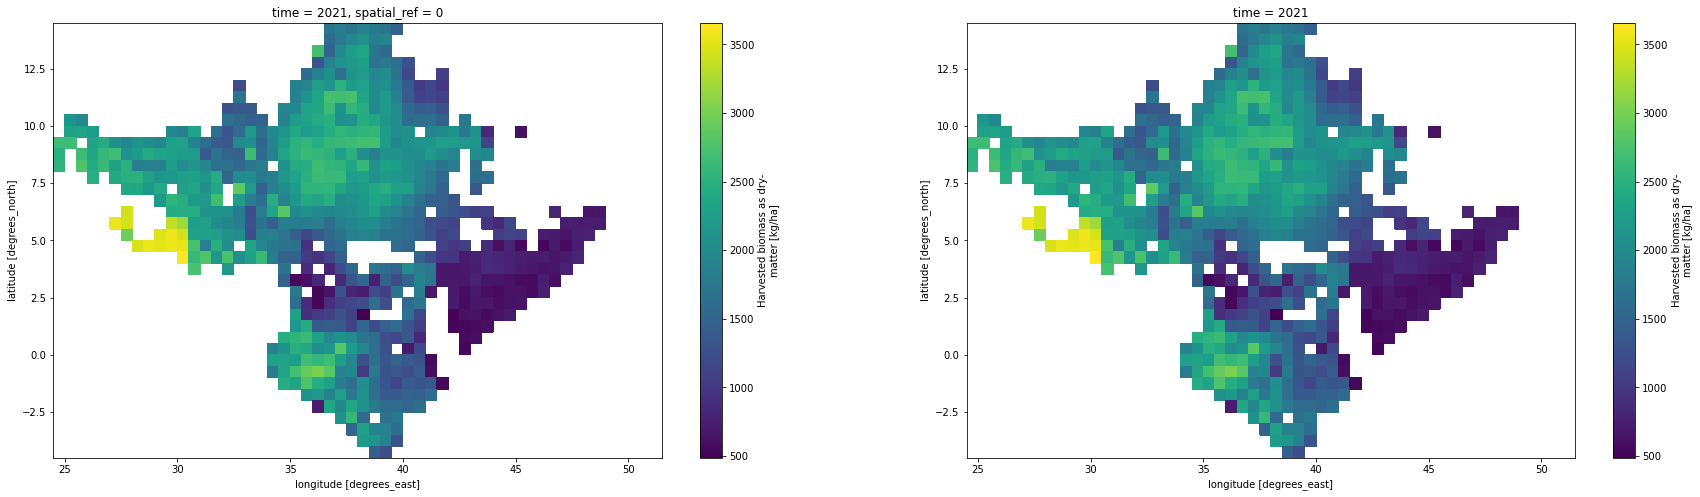

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))
model_output_c.harvest[0,0,:,:].plot(ax=axes[0])
regrid.harvest[0,0,:,:].plot(ax=axes[1])

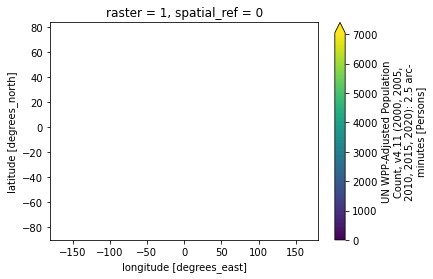

In [24]:
#countries = ['Ethiopia','South Sudan','Somalia','Kenya']
#reference_map = reference_map[reference_map['NAME_0'].isin(countries)]
gpw_c = gpw.rio.clip(reference_map.geometry)
gpw_c\
    .isel(raster=0)\
    [var_name]\
    .plot(robust=True)

### Write model_output to tmp netcdf

In [14]:
#model_output = model_output.rio.clip(reference_map.geometry)
model_output.to_netcdf('sample_tmp.nc')
reference_map.to_netcdf('reference_map_tmp.nc')
#model_output

AttributeError: 'GeoDataFrame' object has no attribute 'to_netcdf'

### Regrid to higher resolution to match other datasets at that resolution.

In [11]:
model_output_regrid = cdo.remapsum("", input='sample_tmp.nc', options='-f nc', returnXDataset=True)

Error in calling operator remapsum with:
>>> cdo -O -f nc -f nc -remapsum, sample_tmp.nc /tmp/cdoPyxlvnheke<<<
STDOUT:

STDERR:cdo    remapsum  : Enter grid description file or name > 
cdo    remapsum (Abort): Too few arguments! Need 1 found 0.



CDOException: (returncode:1) cdo    remapsum  : Enter grid description file or name > 
cdo    remapsum (Abort): Too few arguments! Need 1 found 0.


### Plot

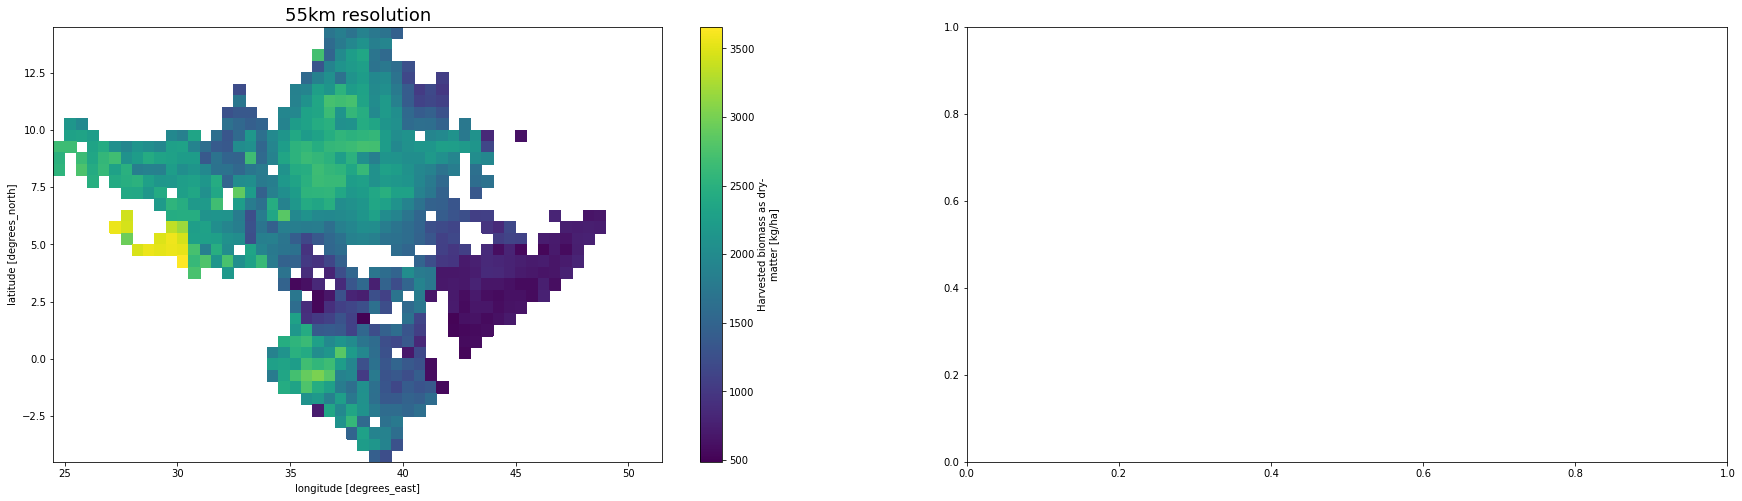

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))

model_output.harvest[0,0,:,:].plot(ax=axes[0])
axes[0].set_title("55km resolution", fontsize = 18)
#ds2.tos[0,:,:].plot(ax=axes[1])
#axes[1].set_title("500km resolution", fontsize = 18)
print()

In [19]:
gpw = xr.open_dataset('/home/user/Downloads/geo/gpw_v4_2pt5_min.nc',decode_coords="all")
gpw = gpw.rio.write_crs(4326)
gpw_c = gpw.rio.clip(reference_map.geometry)
gpw_c


<xarray.Dataset>
Dimensions:                                                                                  (latitude: 469, longitude: 654, raster: 20)
Coordinates:
  * latitude                                                                                 (latitude) float64 ...
  * longitude                                                                                (longitude) float64 ...
  * raster                                                                                   (raster) int32 ...
    spatial_ref                                                                              int64 ...
Data variables:
    UN WPP-Adjusted Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes  (raster, latitude, longitude) float32 ...
Attributes:
    proj4:        +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0...
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 2.8-4)
    date:         2018-11-16 10:00:37

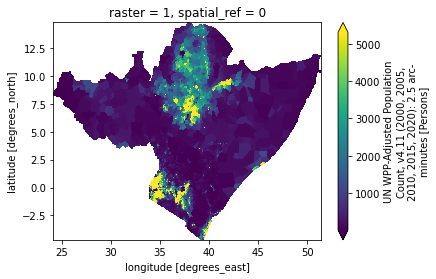

In [24]:
var_name = list(gpw.data_vars.keys())[0]
gpw_c\
    .isel(raster=0)\
    [var_name]\
    .plot(robust=True)
gpw_c.to_netcdf('gpw_tmp.nc')

In [50]:
regrid = cdo.remapbil("gpw_tmp.nc", input="sample_tmp.nc", options='-f nc', returnXDataset = True)

In [51]:
regrid

<xarray.Dataset>
Dimensions:         (time: 4, longitude: 654, latitude: 469, crop: 26)
Coordinates:
  * time            (time) int32 2021 2021 2022 2022
  * longitude       (longitude) float64 24.19 24.23 24.27 ... 51.31 51.35 51.4
  * latitude        (latitude) float64 14.81 14.77 14.73 ... -4.646 -4.688
Dimensions without coordinates: crop
Data variables:
    harvested_area  (time, crop, latitude, longitude) float32 ...
    harvest         (time, crop, latitude, longitude) float32 ...
    production      (time, crop, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Mon Oct 04 11:41:49 2021: cdo -O -f nc -f nc -remapbil,gpw_...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [52]:
model_output

<xarray.Dataset>
Dimensions:         (latitude: 38, longitude: 54, time: 4, crop: 26)
Coordinates:
  * latitude        (latitude) float64 14.25 13.75 13.25 ... -3.25 -3.75 -4.25
  * longitude       (longitude) float64 24.75 25.25 25.75 ... 50.25 50.75 51.25
  * time            (time) int32 2021 2021 2022 2022
    spatial_ref     int64 0
Dimensions without coordinates: crop
Data variables:
    harvested_area  (time, crop, latitude, longitude) float32 nan nan ... nan
    harvest         (time, crop, latitude, longitude) float32 nan nan ... nan
    production      (time, crop, latitude, longitude) float32 nan nan ... nan

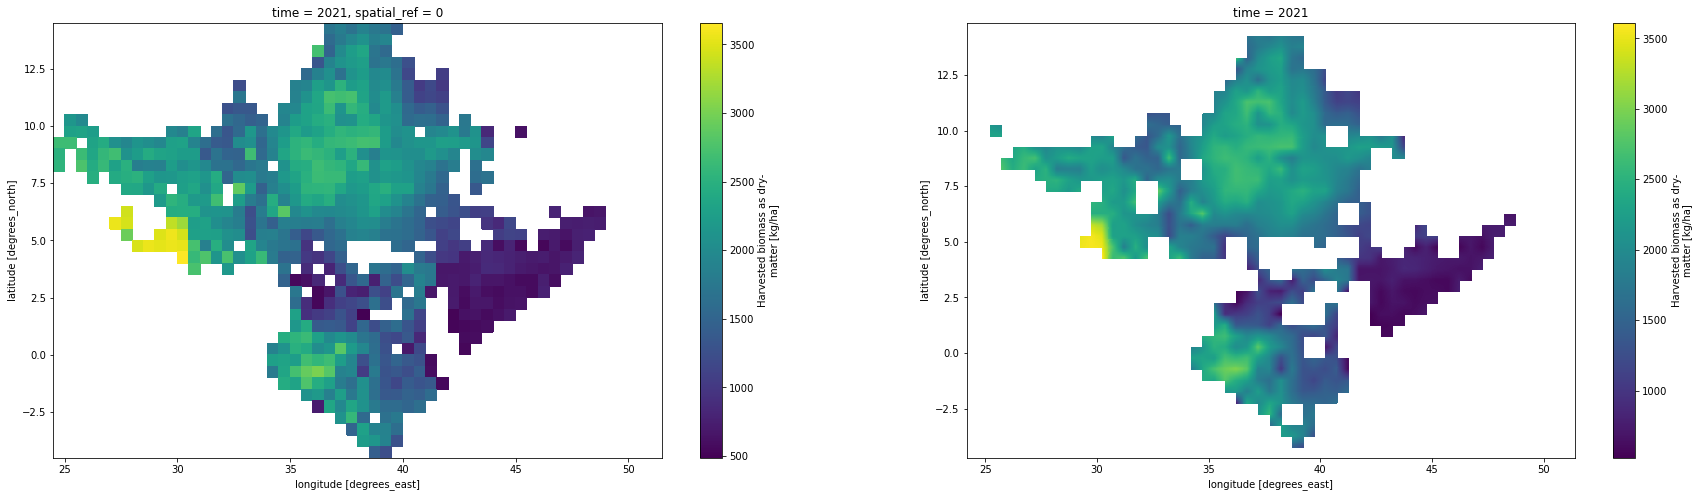

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))

model_output.harvest[0,0,:,:].plot(ax=axes[0])
#axes[0].set_title("55km resolution", fontsize = 18)
regrid.harvest[0,0,:,:].plot(ax=axes[1])
#axes[1].set_title("500km resolution", fontsize = 18)
print()